# Описание проекта

* Условие задачи

Необходимо разработать модель машинного обучения, принимающую
на вход место, категорию аварии и предсказывающую количество
ранений/летальных исходов у взрослых и подростков.

**Описание входных значений**

train.csv — содержит в себе ~3600 зарегистрированных случаев ДТП в
Нижегородской области;

test.сsv — тестовая выборка для предсказания;

sample_submission.csv — образец файла для отправки.

* Метрика
`В качестве метрики выступает Recall.`

# Описание данных проекта

1. `Дата, время` - Когда было совершенно дтп
2. `id` - уникальный идентификатор пользователя
3. `Место` - где произошло событие
4. `Улица` - улица на которой произошло событие
5. `Дом` - Номер дома возле которого произошло ДТП
6. `Дорога` - дорога на которой произошло ДТП
7. `Километр` - метражи
8. `Метр` - метражи
9. `Вид ДТП` - Вид ДТП
10. `Погибло` - Количество смертей взрослых
11. `Погибло детей` - Количество смертей детей
12. `Ранено` - Количество раненых взрослых
13. `Ранено детей` - Количество раненых взрослых

# Иследование проекта

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Константы которые я вынес сразу в начало проекта
RANDOM_STATE = 12345
TEST_SIZE = 0.2
N_SPLITS = 3
CV = ShuffleSplit(n_splits=N_SPLITS, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [3]:
df = pd.read_csv('C:Downloads/train_dataset_train.csv',parse_dates=[['Дата', 'Время']],index_col=[0])
test = pd.read_csv('C:Downloads/test_dataset_test.csv',parse_dates=[['Дата', 'Время']],index_col=[0])

In [4]:
df.shape

(35771, 12)

In [5]:
df.head()

,id,Место,Улица,Дом,Дорога,Километр,Метр,Вид ДТП,Погибло,Погибло детей,Ранено,Ранено детей
Дата_Время,,,,,,,,,,,,
2018-07-13 17:35:00,490103984,"Новгородская область, Великий Новгород",Большая Санкт-Петербургская ул,88,NaN,NaN,NaN,Столкновение,0,0,0,0
2018-11-05 17:10:00,490097169,"Новгородская область, Великий Новгород",Большая Санкт-Петербургская ул,73,NaN,NaN,NaN,Столкновение,0,0,0,0
2020-01-25 14:44:00,490031781,"Новгородская область, Великий Новгород",Хутынская ул,29,NaN,NaN,NaN,NaN,0,0,0,0
2020-11-05 11:30:00,490021246,"Новгородская область, Новгородский район, Сави...",Вишнёвая ул,4,NaN,NaN,NaN,NaN,0,0,0,0
2019-09-01 01:45:00,490041585,"Новгородская область, Окуловский район",NaN,NaN,Нева Москва - Санкт-Петербург (основное направ...,430.0,5.0,Иной вид ДТП,0,0,0,0


In [6]:
df.describe()

,id,Километр,Метр,Погибло,Погибло детей,Ранено,Ранено детей
count,3.577100e+04,10010.000000,10010.000000,35771.000000,35771.000000,35771.000000,35771.000000
mean,4.900607e+08,252.263437,393.842058,0.011238,0.000335,0.171452,0.025020
std,3.525878e+04,274.573930,327.126767,0.122124,0.018313,0.525702,0.179974
min,4.900007e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.900301e+08,14.000000,62.000000,0.000000,0.000000,0.000000,0.000000
50%,4.900595e+08,136.000000,350.000000,0.000000,0.000000,0.000000,0.000000
75%,4.900917e+08,489.000000,700.000000,0.000000,0.000000,0.000000,0.000000
max,4.901250e+08,5793.000000,998.000000,3.000000,1.000000,8.000000,4.000000


**Первичные выводы:**

* Данных достаточно для выполнения задания;
 * видны пропущеные значения будем их заменять;
* Нету выбивающих значений по первичному анализу данных.

In [7]:
# сразу сортеруем по индексу наши выборки
df = df.sort_index()
test = test.sort_index()

In [8]:
df.Место.unique()

array(['Новгородская область, Великий Новгород',
       'Новгородская область, Демянский район',
       'Новгородская область, Окуловский район',
       'Новгородская область, Старорусский район, Старая Русса',
       'Новгородская область, Валдайский район, Валдай, с Зимогорье',
       'Новгородская область, Окуловский район, Окуловка',
       'Новгородская область, Демянский район, Демянск',
       'Новгородская область, Новгородский район',
       'Новгородская область, Валдайский район, Валдай',
       'Новгородская область, Боровичский район, Боровичи',
       'Новгородская область, Боровичский район, Прогресский, д Тини',
       'Новгородская область, Новгородский район, Панковка',
       'Новгородская область, Маловишерский район, Малая Вишера',
       'Новгородская область, Чудовский район',
       'Новгородская область, Крестецкий район',
       'Новгородская область, Валдайский район',
       'Новгородская область, Пестовский район, Пестово',
       'Новгородская область, Хво

In [9]:
df.columns

Index(['id', 'Место', 'Улица', 'Дом', 'Дорога', 'Километр', 'Метр', 'Вид ДТП',
       'Погибло', 'Погибло детей', 'Ранено', 'Ранено детей'],
      dtype='object')

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6788 entries, 2018-01-01 04:00:00 to 2020-12-10 21:50:00
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        6788 non-null   int64  
 1   Место     6788 non-null   object 
 2   Улица     3852 non-null   object 
 3   Дом       3881 non-null   object 
 4   Дорога    1905 non-null   object 
 5   Километр  1904 non-null   float64
 6   Метр      1904 non-null   float64
 7   Вид ДТП   4988 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 477.3+ KB


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35771 entries, 2018-01-01 04:30:00 to 2020-12-10 21:30:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             35771 non-null  int64  
 1   Место          35771 non-null  object 
 2   Улица          20286 non-null  object 
 3   Дом            20460 non-null  object 
 4   Дорога         10011 non-null  object 
 5   Километр       10010 non-null  float64
 6   Метр           10010 non-null  float64
 7   Вид ДТП        25555 non-null  object 
 8   Погибло        35771 non-null  int64  
 9   Погибло детей  35771 non-null  int64  
 10  Ранено         35771 non-null  int64  
 11  Ранено детей   35771 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 3.5+ MB


In [12]:
df['Вид ДТП'].unique()

array(['Столкновение', 'Съезд с дороги', 'Наезд на стоящее ТС',
       'Наезд на препятствие', 'Наезд на животное',
       'Отбрасывание предмета (отсоединение колеса)', 'Опрокидывание',
       'Иной вид ДТП', 'Наезд на пешехода',
       'Наезд на внезапно возникшее препятствие',
       'Наезд на велосипедиста', 'Падение пассажира', 'Падение груза',
       'Наезд на лицо, не являющееся участником дорожного движения (иного участника ДТП), осуществляющее производство работ',
       'Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении',
       'Наезд на лицо, не являющееся участником дорожного движения (иного участника ДТП), осуществляющее несение службы',
       'Наезд на лицо, не являющееся участником дорожного движения (иного участника ДТП), осуществляющее какую-либо другую деятельность',
       nan], dtype=object)

In [13]:
# так как у нас нету информации откуда появились пропуски заменим их на заглушки
df.Улица = df.Улица.fillna('unknown')
df.Дом = df.Дом.fillna('unknown')
df.Дорога = df.Дорога.fillna('unknown')
df.Километр = df.Километр.fillna(0)
df.Метр = df.Метр.fillna(0)
df['Вид ДТП'] = df['Вид ДТП'].fillna('Иной вид ДТП')

In [14]:
# так же проделаем в тесте
test.Улица = test.Улица.fillna('unknown')
test.Дом = test.Дом.fillna('unknown')
test.Дорога = test.Дорога.fillna('unknown')
test.Километр = test.Километр.fillna(0)
test.Метр = test.Метр.fillna(0)
test['Вид ДТП'] = test['Вид ДТП'].fillna('Иной вид ДТП')

In [15]:
# дубликов много, надо удалять они не несут полезной информации,а лишь искажают данные
df.duplicated().sum()

15775

In [16]:
df = df.drop_duplicates()

In [17]:
df.head()

,id,Место,Улица,Дом,Дорога,Километр,Метр,Вид ДТП,Погибло,Погибло детей,Ранено,Ранено детей
Дата_Время,,,,,,,,,,,,
2018-01-01 04:30:00,490082766,"Новгородская область, Великий Новгород",Большая Московская ул,21/6,unknown,0.0,0.0,Столкновение,0,0,2,0
2018-01-01 04:30:00,490082766,"Новгородская область, Великий Новгород",Большая Московская ул,21/6,unknown,0.0,0.0,Столкновение,0,0,0,0
2018-01-01 11:45:00,490082759,"Новгородская область, Демянский район",unknown,unknown,Яжелбицы - Демянск - Залучье - Старая Русса - ...,79.0,800.0,Съезд с дороги,0,0,0,0
2018-01-01 12:00:00,490082751,"Новгородская область, Окуловский район",unknown,unknown,Крестцы - Окуловка - Боровичи,62.0,800.0,Съезд с дороги,0,0,0,0
2018-01-01 16:15:00,490082742,"Новгородская область, Великий Новгород",Свободы ул,16/11,unknown,0.0,0.0,Наезд на стоящее ТС,0,0,0,0


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6788 entries, 2018-01-01 04:00:00 to 2020-12-10 21:50:00
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        6788 non-null   int64  
 1   Место     6788 non-null   object 
 2   Улица     6788 non-null   object 
 3   Дом       6788 non-null   object 
 4   Дорога    6788 non-null   object 
 5   Километр  6788 non-null   float64
 6   Метр      6788 non-null   float64
 7   Вид ДТП   6788 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 477.3+ KB


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19996 entries, 2018-01-01 04:30:00 to 2020-12-10 21:30:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             19996 non-null  int64  
 1   Место          19996 non-null  object 
 2   Улица          19996 non-null  object 
 3   Дом            19996 non-null  object 
 4   Дорога         19996 non-null  object 
 5   Километр       19996 non-null  float64
 6   Метр           19996 non-null  float64
 7   Вид ДТП        19996 non-null  object 
 8   Погибло        19996 non-null  int64  
 9   Погибло детей  19996 non-null  int64  
 10  Ранено         19996 non-null  int64  
 11  Ранено детей   19996 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [20]:
# проверим наши данные на монотонность
df.index.is_monotonic

True

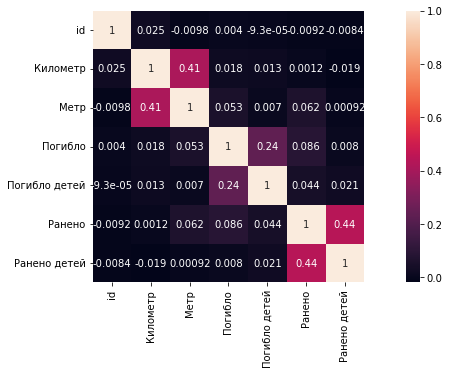

In [21]:
plt.figure(figsize=(15,5))
corr = df.corr()
g = sns.heatmap(corr, square = True, annot=True)

* Каких то сильных зависимостей мы не видим средди наших переменных.
* выделяется зависимость умеренная между метром и километром это обосновано логически.
* так же есть умеренная зависимость межу ранено и раненно детей, что тоже схоже с логигой ДТП на участке. Вероятность ДТП взрослого и ребенка.

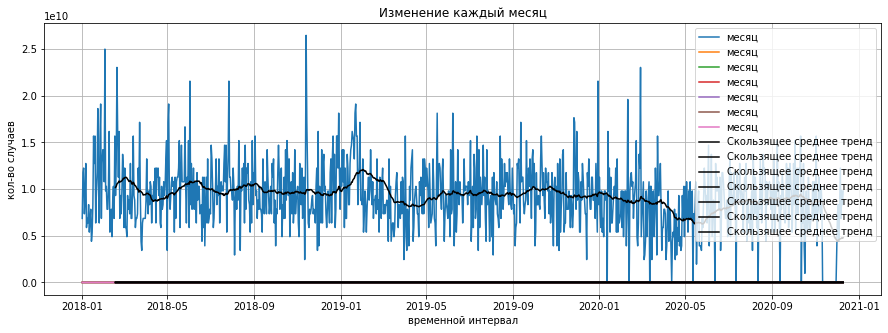

In [22]:
df_new = df.resample('1D').sum()

plt.figure(figsize=(15,5))
plt.title("Изменение каждый месяц")

plt.plot(df_new, label="месяц")
plt.plot(df_new.rolling(24 * 2).mean(), label="Скользящее среднее тренд", color='black')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('временной интервал',fontsize=10)
plt.ylabel('кол-во случаев',fontsize=10)
plt.show()

* Тут мы видим, что на скользящей средней в 2 суток график идёт на спад с каждым годом. Значит количество случаев сокращается - это не может не радовать. 
* Всё равно большое количество дтп присутствует и будем решать эту проблему

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19996 entries, 2018-01-01 04:30:00 to 2020-12-10 21:30:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             19996 non-null  int64  
 1   Место          19996 non-null  object 
 2   Улица          19996 non-null  object 
 3   Дом            19996 non-null  object 
 4   Дорога         19996 non-null  object 
 5   Километр       19996 non-null  float64
 6   Метр           19996 non-null  float64
 7   Вид ДТП        19996 non-null  object 
 8   Погибло        19996 non-null  int64  
 9   Погибло детей  19996 non-null  int64  
 10  Ранено         19996 non-null  int64  
 11  Ранено детей   19996 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Так как у нас задача классификации будем считать, что каждая жертва это трагедия и ровняется она 1. Жертв нету 0.
Чтобы наша модель могла различать будет присутствовать трагедия на участке или нет. Таким образом мы увеличим шанс получить лучше метру Recall, чем на бейзлайне.**

In [24]:
df.loc[df['Погибло'] > 0,'Погибло'] = 1
df.loc[df['Погибло детей'] > 0,'Погибло детей'] = 1
df.loc[df['Ранено'] > 0,'Ранено'] = 1
df.loc[df['Ранено детей'] > 0,'Ранено детей'] = 1

In [25]:
# применим к нашим данным порядковое кодирование нашим переменным
columns_ohe = ['Место','Улица','Дом','Дорога','Вид ДТП']
encoder = OrdinalEncoder()

test_ord = test.copy()
test_ord[columns_ohe] = encoder.fit_transform(test_ord[columns_ohe])
display(test_ord.head(10))

,id,Место,Улица,Дом,Дорога,Километр,Метр,Вид ДТП
Дата_Время,,,,,,,,
2018-01-01 04:00:00,490082770,49.0,117.0,512.0,1.0,0.0,0.0,7.0
2018-01-01 16:35:00,490082733,49.0,125.0,164.0,1.0,0.0,0.0,14.0
2018-01-01 21:00:00,490082699,90.0,401.0,148.0,1.0,0.0,0.0,9.0
2018-01-02 11:45:00,490087501,30.0,173.0,42.0,1.0,0.0,0.0,14.0
2018-01-02 12:30:00,490087486,8.0,299.0,386.0,1.0,0.0,0.0,14.0
2018-01-02 14:45:00,490087455,163.0,116.0,364.0,1.0,0.0,0.0,9.0
2018-01-02 15:55:00,490087453,8.0,249.0,225.0,1.0,0.0,0.0,9.0
2018-01-02 17:15:00,490087430,49.0,181.0,215.0,1.0,0.0,0.0,14.0
2018-01-02 17:50:00,490087408,49.0,98.0,527.0,1.0,0.0,0.0,8.0


In [26]:
# применим к нашим данным порядковое кодирование нашим переменным
columns_ohe = ['Место','Улица','Дом','Дорога','Вид ДТП']
encoder = OrdinalEncoder()

df_ord = df.copy()
df_ord[columns_ohe] = encoder.fit_transform(df_ord[columns_ohe])
display(df_ord.head(10))

,id,Место,Улица,Дом,Дорога,Километр,Метр,Вид ДТП,Погибло,Погибло детей,Ранено,Ранено детей
Дата_Время,,,,,,,,,,,,
2018-01-01 04:30:00,490082766,86.0,59.0,432.0,2.0,0.0,0.0,15.0,0,0,1,0
2018-01-01 04:30:00,490082766,86.0,59.0,432.0,2.0,0.0,0.0,15.0,0,0,0,0
2018-01-01 11:45:00,490082759,96.0,24.0,1118.0,171.0,79.0,800.0,16.0,0,0,0,0
2018-01-01 12:00:00,490082751,259.0,24.0,1118.0,71.0,62.0,800.0,16.0,0,0,0,0
2018-01-01 16:15:00,490082742,86.0,464.0,276.0,2.0,0.0,0.0,10.0,0,0,0,0
2018-01-01 16:15:00,490082742,86.0,464.0,276.0,2.0,0.0,0.0,10.0,0,0,1,0
2018-01-01 18:15:00,490082726,365.0,34.0,643.0,2.0,0.0,0.0,15.0,0,0,0,0
2018-01-01 18:30:00,490082720,86.0,512.0,621.0,2.0,0.0,0.0,16.0,0,0,0,0
2018-01-01 19:00:00,490082719,58.0,478.0,772.0,2.0,0.0,0.0,9.0,0,0,0,0


In [27]:
df_train, df_test = train_test_split(df_ord, test_size=0.3, random_state=12345)

In [28]:
features_train, target_train = df_train.drop(['Погибло','Погибло детей','Ранено','Ранено детей'], axis = 1), df_train[['Погибло','Погибло детей','Ранено','Ранено детей']]
features_valid, target_valid = df_test.drop(['Погибло','Погибло детей','Ранено','Ранено детей'], axis = 1), df_test[['Погибло','Погибло детей','Ранено','Ранено детей']]

In [29]:
# Стандартизируем наши данные ТОЛЬКО для фьючер
scaler_1 = StandardScaler()
scaler_1.fit(features_train)
features_train_ord = scaler_1.transform(features_train)
features_valid_ord = scaler_1.transform(features_valid)
test_ord = scaler_1.transform(test_ord)

In [30]:
display(target_train.head(5))
display(features_train.head(5))
display(target_valid.head(5))
display(features_valid.head(5))

,Погибло,Погибло детей,Ранено,Ранено детей
Дата_Время,,,,
2019-01-02 16:30:00,0,0,0,0
2018-02-01 04:40:00,1,0,0,0
2018-08-09 23:27:00,0,0,0,0
2019-11-11 12:00:00,0,0,0,0
2020-01-03 11:35:00,0,0,0,0


,id,Место,Улица,Дом,Дорога,Километр,Метр,Вид ДТП
Дата_Время,,,,,,,,
2019-01-02 16:30:00,490037804,178.0,24.0,1118.0,38.0,0.0,900.0,15.0
2018-02-01 04:40:00,490082682,178.0,24.0,1118.0,128.0,13.0,450.0,8.0
2018-08-09 23:27:00,490112211,56.0,24.0,1118.0,1.0,371.0,520.0,15.0
2019-11-11 12:00:00,490076656,59.0,24.0,1118.0,2.0,0.0,0.0,10.0
2020-01-03 11:35:00,490027556,365.0,24.0,1118.0,2.0,0.0,0.0,1.0


,Погибло,Погибло детей,Ранено,Ранено детей
Дата_Время,,,,
2018-02-23 14:10:00,0,0,1,0
2018-08-30 12:00:00,0,0,1,0
2020-03-23 04:30:00,0,0,0,0
2020-03-16 12:30:00,0,0,0,0
2018-12-23 14:50:00,0,0,0,0


,id,Место,Улица,Дом,Дорога,Километр,Метр,Вид ДТП
Дата_Время,,,,,,,,
2018-02-23 14:10:00,490083584,86.0,24.0,1118.0,2.0,0.0,0.0,15.0
2018-08-30 12:00:00,490105636,86.0,59.0,906.0,2.0,0.0,0.0,10.0
2020-03-23 04:30:00,490025049,338.0,24.0,1118.0,171.0,136.0,800.0,1.0
2020-03-16 12:30:00,490025754,365.0,248.0,357.0,2.0,0.0,0.0,1.0
2018-12-23 14:50:00,490121949,86.0,430.0,823.0,2.0,0.0,0.0,15.0


линейнная регрессия

In [31]:
from sklearn.naive_bayes import GaussianNB # 0.501
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # 0.499
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import BayesianRidge

# Поиск лучшей модели и проверка на обучающей выборке

## Метод ближайших соседей

In [32]:
"""
knn = KNeighborsClassifier()
k_range = list(range(1, 51))
param_grid = {'n_neighbors': k_range,
              'weights': ['uniform','distance'],
              'metric': ['euclidean','manhattan']
             }
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=3, scoring='r2',verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(features_train_ord, target_train)
print(grid_search.best_params_)
"""

"\nknn = KNeighborsClassifier()\nk_range = list(range(1, 51))\nparam_grid = {'n_neighbors': k_range,\n              'weights': ['uniform','distance'],\n              'metric': ['euclidean','manhattan']\n             }\n  \n# defining parameter range\ngrid = GridSearchCV(knn, param_grid, cv=3, scoring='r2',verbose=1)\n  \n# fitting the model for grid search\ngrid_search=grid.fit(features_train_ord, target_train)\nprint(grid_search.best_params_)\n"

In [33]:
knn_train = KNeighborsClassifier(n_neighbors=11,weights='uniform', metric='manhattan').fit(features_train_ord, target_train)
pred_knn_train = knn_train.predict(features_valid_ord)
score_knn_train = 0

score_knn_train += recall_score(target_valid["Погибло"], pred_knn_train[:,0], average='macro')
score_knn_train += recall_score(target_valid["Погибло детей"], pred_knn_train[:,1], average='macro')
score_knn_train += recall_score(target_valid["Ранено"], pred_knn_train[:,2], average='macro')
score_knn_train += recall_score(target_valid["Ранено детей"], pred_knn_train[:,3], average='macro')
print("Recall score:", score_knn_train / 4)

Recall score: 0.5013909060146237


##  Решающее дерево

In [34]:
"""
tree_para = {
    'max_depth': range(1, 100),
    'min_samples_split': range(1, 20)
    
}
GS_grid = GridSearchCV(DecisionTreeClassifier(),
                  tree_para,
                  cv = 3,
                       
                      )
GS_grid.fit(features_train_ord, target_train)
print(GS_grid.best_params_)
"""

"\ntree_para = {\n    'max_depth': range(1, 100),\n    'min_samples_split': range(1, 20)\n    \n}\nGS_grid = GridSearchCV(DecisionTreeClassifier(),\n                  tree_para,\n                  cv = 3,\n                       \n                      )\nGS_grid.fit(features_train_ord, target_train)\nprint(GS_grid.best_params_)\n"

In [35]:
DTC_train = DecisionTreeClassifier(random_state= RANDOM_STATE, max_depth= 3, min_samples_split= 3).fit(features_train_ord, target_train)
pred_DTC_train = DTC_train.predict(features_valid_ord)
score_DTC_train = 0

score_DTC_train += recall_score(target_valid["Погибло"], pred_DTC_train[:,0], average='macro')
score_DTC_train += recall_score(target_valid["Погибло детей"], pred_DTC_train[:,1], average='macro')
score_DTC_train += recall_score(target_valid["Ранено"], pred_DTC_train[:,2], average='macro')
score_DTC_train += recall_score(target_valid["Ранено детей"], pred_DTC_train[:,3], average='macro')
print("Recall score:", score_DTC_train / 4)

Recall score: 0.5067648754784619


## Случайный лес

In [36]:
"""
search_space = {
    'n_estimators' : [100, 200, 500],
    'criterion': ['gini','entropy'],
    'max_features': range(1,15),
    'min_samples_split': range(1,15),
}
GS = GridSearchCV(RandomForestClassifier(),
                  search_space,
                  cv = CV
)
GS.fit(features_train_ord, target_train)

GS.best_params_
"""

"\nsearch_space = {\n    'n_estimators' : [100, 200, 500],\n    'criterion': ['gini','entropy'],\n    'max_features': range(1,15),\n    'min_samples_split': range(1,15),\n}\nGS = GridSearchCV(RandomForestClassifier(),\n                  search_space,\n                  cv = CV\n)\nGS.fit(features_train_ord, target_train)\n\nGS.best_params_\n"

In [37]:
clf_train = RandomForestClassifier(criterion= 'entropy',min_samples_split=15,max_features= 8,n_estimators= 200).fit(features_train_ord, target_train)
pred_clf_train = clf_train.predict(features_valid_ord)
score_clf_train = 0

score_clf_train += recall_score(target_valid["Погибло"], pred_clf_train[:,0], average='macro')
score_clf_train += recall_score(target_valid["Погибло детей"], pred_clf_train[:,1], average='macro')
score_clf_train += recall_score(target_valid["Ранено"], pred_clf_train[:,2], average='macro')
score_clf_train += recall_score(target_valid["Ранено детей"], pred_clf_train[:,3], average='macro')
print("Recall score:", score_clf_train / 4)

Recall score: 0.4976048713983361


In [38]:

DTC_train = DecisionTreeClassifier(random_state= RANDOM_STATE, max_depth= 3, min_samples_split= 3).fit(features_train_ord, target_train)
pred_DTC_test = DTC_train.predict(test_ord)
submission = pd.DataFrame({'Погибло': pred_DTC_test[:,0],
                           'Погибло детей': pred_DTC_test[:,1],
                           'Ранено': pred_DTC_test[:,2],
                           'Ранено детей': pred_DTC_test[:,3],
                           
                      })


In [39]:
# создание отдельного датафрейма с результатами
pddf = pd.read_csv('C:Downloads/sample_solution.csv')
submission['id'] = pddf['id']
submission = submission[['id', 'Погибло', 'Погибло детей', 'Ранено', 'Ранено детей']]
submission.to_csv('Tree_top_1.csv',index=False)


**Вывод:**

**Лучшей моделью для новгородского проекта которую я нашёл, оказалась решающее дерево с показателем 0.5067 на обучающей выборке.**